<a href="https://colab.research.google.com/github/ivynasantino/vies-discursos-deputados/blob/master/reports/vies_de_discursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Processamento de linguagem natural aplicada à análise de discursos de deputados

Contexto: 
- **Contextualização**

- **Objetivo da pesquisa:** Detectar viés de determinados termos(ainda definir) em discursos dos deputados federais da legislatura 56

- **Dados utilizados:** Reunião da CCJC da PEC 06/2019 - Reforma da previdência

- **Onde se encontra o dado:** A Câmara de deputados dispõe de notas taquigrafadas de cada reunião na sua [página]().

- **Ferramentas utilizadas:**
  - [Leg.go]() 
  - [Dados abertos]()
  - [PyPdf2]()
  - [Extrator de discursos]()
  - [Gensim]()
  - [rcongresso]()
  
- **Algoritmos utilizados:** 

In [89]:
# @title Imports
import pandas as pd
import numpy as np
import math 
import operator
import re
import collections

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec

from pyemd import emd

from IPython.display import HTML, display
import tabulate

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Base de dados

In [0]:
# @title Dataframe de discursos
url = "https://raw.githubusercontent.com/ivynasantino/vies-discursos-deputados/master/data/all_discursos.csv"
discursos = pd.read_csv(url)

In [5]:
discursos.head()

,data,autor,partido,uf,discurso
0,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,"Havendo número regimental, declaro aberta a pr..."
1,09/04/2019,AFONSO MOTTA,PDT,RS,"Questão de ordem, Sr. Presidente."
2,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,Questão de ordem do Deputado Afonso Motta.
3,09/04/2019,AFONSO MOTTA,PDT,RS,"Sr. Presidente, o fundamento da minha questão ..."
4,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,"Só um minuto, Deputado. Deputados, por favor, ..."


### Processamento dos dados

- Remover stopwords

In [6]:
nltk.download('stopwords')

# removendo stopwords
default_stopwords = set(stopwords.words('portuguese'))
stopwords_complement = ["","neste","és", "é", "somos", "sois", "são", "era", "eras", "éreis", "foste", "fostes", "foras",	"fôreis",	"serás", "sereis", "serão",	"serias", "seríeis", "sejas", "sejais", "fosses", "fôsseis", "fores", "fordes", "sê", "sejas", "sejais", "ser", "seres", "sermos",	"serdes",	"serem", "sobre", "é"]

stopwords_complement.extend(default_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# @title Importando modelo 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [12]:
# @title Carregando modelo
model = Word2Vec.load('./drive/My Drive/tcc/tcc/dados/modelo/model.txt')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### TSNE e PCA

In [0]:
def tsnescatterplot(model, word, list_names):
   
    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


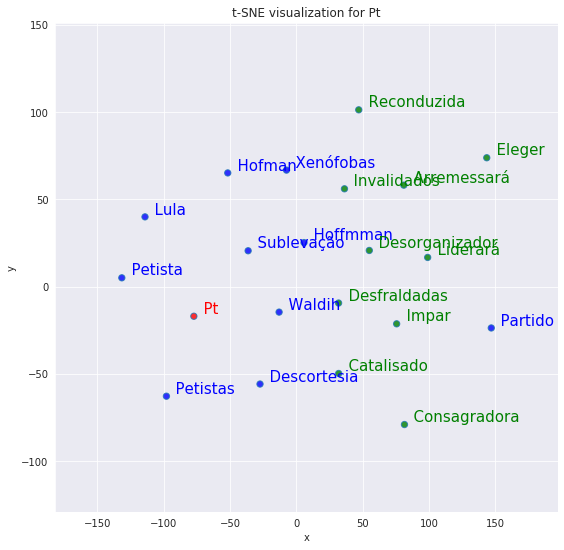

In [106]:
tsnescatterplot(model, 'pt', [t[0] for t in model.wv.most_similar(positive=["eleição"], topn=20)][10:])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


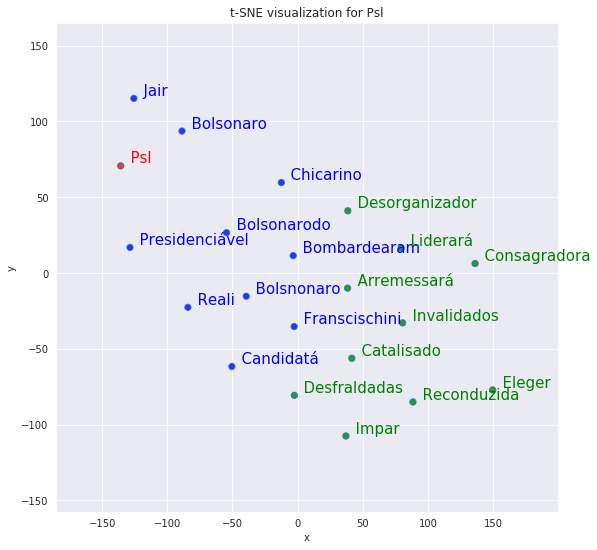

In [105]:
tsnescatterplot(model, 'psl', [t[0] for t in model.wv.most_similar(positive=["eleição"], topn=20)][10:])

### Proximidade de discursos

In [0]:
def discursos_2_array(id_discursos):
    words = re.split(r'\W+', discursos.loc[id_discursos].discurso)
    no_stopwords_discursos = []
    for word in words:
        if word.lower() not in stopwords_complement:
            no_stopwords_discursos.append(word.lower())
    return no_stopwords_discursos

In [0]:
def discursos_2_embeddings(discursos_id):
    words = discursos_2_array(discursos_id)
    
    embed_words = {}
    for word in words:
                
        try:
            embed_words[w] = model[w]
        except:
            continue      
        
    return words, embed_words

In [0]:
def wmdistance(d1, d2):
    d1, d1_embed = discursos_2_embeddings(d1)
    d2, d2_embed = discursos_2_embeddings(d2)
    
    return model.wv.wmdistance(d1, d2)

In [69]:
discursos.discurso.loc[540]

'V.Exa., de forma ilegal, concedeu o tempo integral à Deputada. Então, V.Exa...'

In [68]:
discursos.discurso.loc[1]

'Questão de ordem, Sr. Presidente.'

In [16]:
wmdistance(540, 1)

3.9547515458838616

In [0]:
def similarity(discursos_ids):
    score = {}
    for i in range(0, discursos_ids):
        score[i] = wmdistance(discursos_ids, i)
    
    sorted_discursos = sorted(score.items(), key=operator.itemgetter(1))
    return [(i, discursos.loc[i].autor, discursos.loc[i].discurso, "{0:.2f}".format(j)) for i, j in sorted_discursos[1:4]]

In [0]:
def info_disc(discurso_id):
  print(discursos.loc[discurso_id].autor + " (" + discursos.loc[discurso_id].partido + " - " + discursos.loc[discurso_id].uf + ")")
  print(discursos.loc[discurso_id].discurso)

In [86]:
info_disc(540)

ERIKA KOKAY (PT - DF)
V.Exa., de forma ilegal, concedeu o tempo integral à Deputada. Então, V.Exa...


In [88]:
similarity(540)

[(70,
  'FELIPE FRANCISCHINI',
  'Deputada, V.Exa. não é membro da Comissão. Então, não cabe questão de ordem.',
  '2.83'),
 (537,
  'FELIPE FRANCISCHINI',
  'Após a fala da Deputada Joenia Wapichana, concedo a palavra a V.Exa.',
  '2.96'),
 (23,
  'FELIPE FRANCISCHINI',
  'É incidental à questão. Tem a palavra V.Exa., rapidamente, Deputada.',
  '3.05')]

### Análises e construção dos docs

- Análise de similaridade/agrupamento de discursos
- Análise de viés nos discursos para termos como: reforma da previdência, bolsonaro, lula livre

In [0]:
def display_table(list_model):
  list_model.insert(0, ("Word", "Most similar"))
  return display(HTML(tabulate.tabulate(list_model, tablefmt='html')))

In [59]:
w1 = ["psl", "eleição"]
psl_eleicao = model.wv.most_similar(positive=w1, topn=15)
display_table(psl_eleicao)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
palmômetro,0.7710034251213074
jair,0.7608100771903992
polariza,0.7500396966934204
bolsonaro,0.7429354786872864
classificara,0.734083354473114
revolveu,0.725829005241394
presidenciável,0.7198766469955444
presidencial,0.7191309928894043
bombardearam,0.7149540185928345
disputariam,0.7136538624763489


In [60]:
w2 = ["pt", "eleição"]
pt_eleicao = model.wv.most_similar(positive=w2,topn=15)
display_table(pt_eleicao)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
delirando,0.7174264788627625
autointitulada,0.7106168270111084
presidencial,0.70921790599823
afunile,0.7086635828018188
indultaria,0.7041963934898376
esteticamente,0.7036284804344177
registrarão,0.7000104784965515
mingúem,0.6990824937820435
figurante,0.6944537162780762
enterrarmos,0.6916728615760803


In [61]:
w3 = ["dilma", "pt"]
w4 = ["temer"]
imp = model.wv.most_similar(positive=w3, negative=w4, topn=15)
display_table(imp)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
rousseff,0.6882956624031067
cassada,0.5784278512001038
satirizados,0.5509670972824097
petistas,0.5499893426895142
vistou,0.548947811126709
autointitulada,0.522057294845581
presidenta,0.518711268901825
entronizou,0.5183515548706055
petista,0.5174095630645752
proa,0.5038093328475952
